In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes

In [3]:
dataname = "m4_daily"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_daily


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/test/data.json


In [4]:
dataname = "m4_daily_domain"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily_domain.


In [4]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [5]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='D'),
 'target': array([1017.1, 1019.3, 1017. , ..., 2022.1, 2031.6, 2029.7], dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json'), line=1), row=1)}

In [6]:
dataset.metadata.feat_static_cat

[CategoricalFeatureInfo(name='feat_static_cat', cardinality='4227')]

In [7]:
[feat_static_cat.cardinality for feat_static_cat in dataset.metadata.feat_static_cat]

['4227']

### Plot Series

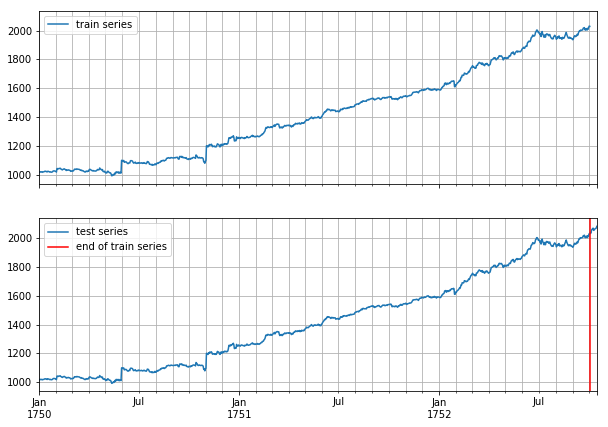

In [8]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## DeepAR - with 2 static features

In [9]:
# gluonts
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# DeepAREstimator
from gluonts.model.deepar import DeepAREstimator

INFO:root:Using CPU


In [10]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df


In [55]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_weekly_domain", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.03it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 14.273 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.249107
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.75it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 12.919 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.842752
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.80it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[2] Elapsed time 12.833 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.715181
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.16it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[3] Elapsed time 13.982 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.56it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[72] Elapsed time 13.239 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.694953
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.40it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 13.523 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.739723
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.62it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 13.131 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.727140
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.80it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[75] Elapsed time 12.839 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.697670
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:14<00:00,  7.01it/s, avg_epoch_

       MASE     sMAPE     MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.647697  0.086228  23.8142            0.063018            0.026098    42   

   epochs  num_batches  
0     100          100  
Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.85it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 17.111 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.347654
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.74it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[1] Elapsed time 14.844 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.731935
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.43it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 15.560 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.617084
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.02it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 12.471 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:13<00:00,  7.62it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[72] Elapsed time 13.137 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.739076
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:14<00:00,  7.09it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[73] Elapsed time 14.116 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.702046
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  7.94it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[74] Elapsed time 12.600 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.712714
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:18<00:00,  5.44it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[75] Elapsed time 18.394 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.689485
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:16<00:00,  6.21it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[76] Elapsed time 16.111

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.623139  0.078814  25.410871            0.058675            0.027255   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.87it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[0] Elapsed time 14.564 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.278435
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.60it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 13.165 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.902134
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.18it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 16.214 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.797005
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.05it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 16.537 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'

INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.85it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[72] Elapsed time 12.748 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.698361
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.95it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[73] Elapsed time 12.583 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.813056
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[74] Elapsed time 12.048 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.758513
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.32it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[75] Elapsed time 12.022 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.714763
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.427714  0.080337  21.225715            0.058028            0.027024   

   seed  epochs  num_batches  
0    44     100          100  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.56it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[0] Elapsed time 13.237 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.609840
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.26it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 12.109 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.858014
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.25it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[2] Elapsed time 12.128 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.593339
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.27it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[3] Elapsed time 13.769 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[72] Elapsed time 11.798 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.724213
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.94it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 11.190 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.736934
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.32it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[74] Elapsed time 12.029 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.719512
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.11it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[75] Elapsed time 12.338 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.758608
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.61it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[76] Elapsed time 11.614 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.731946
INFO

       MASE     sMAPE     MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.532896  0.082743  22.5323            0.061719            0.027687    45   

   epochs  num_batches  
0     100          100  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:26<00:00,  3.81it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[0] Elapsed time 26.285 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.185408
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:21<00:00,  4.69it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1] Elapsed time 22.016 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.828843
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.85it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[2] Elapsed time 17.090 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.635259
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.18it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[3] Elapsed time 19.327 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:17<00:00,  5.81it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[72] Elapsed time 17.219 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.780194
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:19<00:00,  5.07it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[73] Elapsed time 19.739 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.706591
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:15<00:00,  6.46it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 15.487 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.727589
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:15<00:00,  6.44it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[75] Elapsed time 15.528 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.755305
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:19<00:00,  5.21it/s, avg_epoch

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.555657  0.080359  20.955645            0.059487            0.027132   

   seed  epochs  num_batches  
0    46     100          100  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.85it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[0] Elapsed time 12.750 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.304906
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.02it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[1] Elapsed time 16.609 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.811662
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:23<00:00,  4.23it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[2] Elapsed time 23.662 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.671203
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.70it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[3] Elapsed time 14.940 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.99it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[36] Elapsed time 11.134 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.868941
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.12it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[37] Elapsed time 14.047 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.868302
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.53it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[38] Elapsed time 15.324 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.816277
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.77it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[39] Elapsed time 17.348 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.855502
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.30it/s, avg_epoch_loss=5.82

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.974403  0.085861  25.400273            0.062869            0.027911   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.55it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[0] Elapsed time 15.280 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.478983
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.93it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[1] Elapsed time 14.440 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.849439
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.37it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 13.575 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.621795
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.38it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 13.560 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:12<00:00,  7.71it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[72] Elapsed time 12.972 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.740380
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.50it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[73] Elapsed time 13.341 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.711495
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[74] Elapsed time 12.467 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.772928
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  7.99it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[75] Elapsed time 12.520 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.710616
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.54it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[76] Elapsed time 13.26

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.688655  0.078402  23.730044            0.058814            0.026328   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.06it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 16.499 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.274832
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.84it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 12.758 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.901552
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.18it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[2] Elapsed time 12.233 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.640127
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[3] Elapsed time 12.418 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[72] Elapsed time 12.462 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.745766
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.33it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[73] Elapsed time 13.656 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.750547
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:14<00:00,  6.96it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 14.374 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.732204
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[75] Elapsed time 12.046 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.726268
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[76] Elapsed time 12.4

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.877221  0.088606  27.282367            0.064581            0.029408   

   seed  epochs  num_batches  
0    49     100          100  
Seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.80it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[0] Elapsed time 12.827 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.228729
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.19it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 12.215 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.835405
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.23it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[2] Elapsed time 12.155 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.737825
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.05it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[3] Elapsed time 14.201 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[72] Elapsed time 14.986 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.816377
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.27it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[73] Elapsed time 12.107 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.771947
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.65it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 13.079 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.725435
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.79it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[75] Elapsed time 12.838 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.749768
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.01it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[76] Elapsed time 12.491 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.744976
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.921541  0.082299  35.811205            0.062046            0.031452   

   seed  epochs  num_batches  
0    50     100          100  
Seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.77it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[0] Elapsed time 14.784 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.214874
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.58it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[1] Elapsed time 13.193 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.766113
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.08it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 12.378 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.616317
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 12.407 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:12<00:00,  8.21it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[72] Elapsed time 12.190 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.742276
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.25it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 12.126 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.726250
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.20it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[74] Elapsed time 12.200 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.687006
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.11it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[75] Elapsed time 12.338 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.660340
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.24it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 12.1

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.896752  0.082645  27.99451            0.062774            0.027616    51   

   epochs  num_batches  
0     100          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,2.647697,0.086228,23.814200,0.063018,0.026098,42,100,100
0,2.623139,0.078814,25.410871,0.058675,0.027255,43,100,100
0,2.427714,0.080337,21.225715,0.058028,0.027024,44,100,100
0,2.532896,0.082743,22.532300,0.061719,0.027687,45,100,100
0,2.555657,0.080359,20.955645,0.059487,0.027132,46,100,100
0,2.974403,0.085861,25.400273,0.062869,0.027911,47,100,100
0,2.688655,0.078402,23.730044,0.058814,0.026328,48,100,100
0,2.877221,0.088606,27.282367,0.064581,0.029408,49,100,100
0,2.921541,0.082299,35.811205,0.062046,0.031452,50,100,100
0,2.896752,0.082645,27.994510,0.062774,0.027616,51,100,100


In [56]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_weekly", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.07it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[0] Elapsed time 12.400 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.333318
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.14it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1] Elapsed time 14.011 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.825292
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[2] Elapsed time 12.038 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.714820
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.41it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 11.897 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.51

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.723969
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[73] Elapsed time 12.410 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.720925
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.44it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[74] Elapsed time 13.449 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.746610
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.48it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[75] Elapsed time 15.443 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.713437
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.17it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[76] Elapsed time 16.214 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.730055
INFO:root:Epoch[77] Learning rate is 0.001
100%|████

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.675979  0.08395  29.957781            0.062653            0.031221    42   

   epochs  num_batches  
0     100          100  
Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:56<00:00,  1.77it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[0] Elapsed time 56.605 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.661190
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:44<00:00,  2.25it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[1] Elapsed time 44.491 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.848373
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:30<00:00,  3.33it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[2] Elapsed time 30.095 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.670903
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [01:06<00:00,  1.50it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[3] Elapsed time 66.898 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.54

INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.774737
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:29<00:00,  3.36it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[78] Elapsed time 29.818 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.755154
INFO:root:Loading parameters from best epoch (68)
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 100/100 [00:32<00:00,  3.10it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[79] Elapsed time 32.275 seconds
INFO:root:Epoch[79] Evaluation metric 'epoch_loss'=5.725712
INFO:root:Epoch[80] Learning rate is 0.0005
100%|██████████| 100/100 [00:25<00:00,  3.98it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[80] Elapsed time 25.112 seconds
INFO:root:Epoch[80] Evaluation metric 'epoch_loss'=5.722851
INFO:root:Epoch[81] Learning rate is 0.0005
100%|██████████| 100/100 [00:28<00:00,  3.56it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[81] Elapsed time 28.113 seconds
INFO:root:Epoch[81] Evaluation metric 'epoch_loss'=5.708067

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.685703  0.083277  28.105718            0.061119            0.028726   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:24<00:00,  4.11it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 24.335 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.855830
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.48it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[1] Elapsed time 22.314 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.882931
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.39it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[2] Elapsed time 22.776 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.653240
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.47it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 22.391 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.41

INFO:root:Epoch[72] Elapsed time 7.066 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.672958
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 14.02it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[73] Elapsed time 7.139 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.809516
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 13.96it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[74] Elapsed time 7.173 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.735798
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.69it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[75] Elapsed time 7.888 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.694645
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 14.16it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[76] Elapsed time 7.067 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.745840
I

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.553431  0.085053  22.71406            0.061923            0.028575    44   

   epochs  num_batches  
0     100          100  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.61it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 7.355 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.407360
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.98it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 7.157 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.794106
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.27it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 7.016 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.622933
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.26it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[3] Elapsed time 7.017 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.543541

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.14it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[73] Elapsed time 7.077 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.695781
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.33it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[74] Elapsed time 6.984 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.764650
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.32it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[75] Elapsed time 7.518 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.778142
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.50it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[76] Elapsed time 8.708 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.746556
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.35it/s, avg_epoch_loss=5.77]
INF

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.551216  0.083366  23.017125            0.061141            0.026905   

   seed  epochs  num_batches  
0    45     100          100  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.00it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[0] Elapsed time 7.152 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.326514
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.81it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[1] Elapsed time 7.248 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.853384
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.31it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 6.992 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.617557
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.40it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[3] Elapsed time 6.951 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.553704

100%|██████████| 100/100 [00:08<00:00, 11.13it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[72] Elapsed time 9.000 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.788570
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.40it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[73] Elapsed time 6.951 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.714600
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[74] Elapsed time 6.857 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.737887
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.42it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[75] Elapsed time 6.942 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.770974
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.43it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[76] Elapsed time 6.93

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.480305  0.092277  21.864018             0.06577            0.027685   

   seed  epochs  num_batches  
0    46     100          100  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.86it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[0] Elapsed time 7.226 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.307405
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.18it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1] Elapsed time 7.596 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.824542
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.30it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[2] Elapsed time 8.141 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.645937
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.44it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 6.929 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.514965

INFO:root:Epoch[72] Elapsed time 6.922 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.744076
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.65it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 6.830 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.741253
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.51it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[74] Elapsed time 6.898 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.766386
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.84it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[75] Elapsed time 6.746 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.730355
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:06<00:00, 14.82it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[76] Elapsed time 6.752 seconds
INFO:root:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.749931  0.083731  28.312247            0.060692            0.027068   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.18it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[0] Elapsed time 7.059 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.429280
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.85it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1] Elapsed time 6.740 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.820354
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.68it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[2] Elapsed time 6.817 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.670751
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.88it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 6.727 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.511574

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.721156
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:07<00:00, 13.94it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[73] Elapsed time 7.177 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.703478
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[74] Elapsed time 6.855 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.756778
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[75] Elapsed time 6.856 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.689615
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.59it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[76] Elapsed time 6.860 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.692570
INFO:root:Epoch[77] Learning rate is 0.0005
100%|████

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.700239  0.085821  27.460034            0.063158            0.029634   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.27it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[0] Elapsed time 7.013 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.449640
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.13it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 7.083 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.897352
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.04it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 6.655 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.623805
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.22it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[3] Elapsed time 7.041 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.452351


INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.722645
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.89it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[73] Elapsed time 6.721 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.746408
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.81it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[74] Elapsed time 6.759 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.741140
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 15.01it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[75] Elapsed time 6.669 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.728174
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:07<00:00, 14.21it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[76] Elapsed time 7.045 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.710951
INFO:root:Epoch[77] Learning rate is 0.0005
100%|███

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.152744  0.099731  36.241247            0.072664            0.036317   

   seed  epochs  num_batches  
0    49     100          100  
Seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.32it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 6.992 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.352016
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.63it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 6.842 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.862839
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.46it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[2] Elapsed time 6.921 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.723205
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.80it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[3] Elapsed time 6.762 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.574496

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.784105
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.95it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[73] Elapsed time 6.692 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.768236
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.88it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 6.727 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.734738
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.85it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[75] Elapsed time 6.740 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.749332
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.79it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[76] Elapsed time 6.768 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.759117
I

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.551079  0.086004  22.716032            0.061955            0.025813   

   seed  epochs  num_batches  
0    50     100          100  
Seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.11it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[0] Elapsed time 10.991 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.317519
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.66it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[1] Elapsed time 13.063 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.879192
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.95it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[2] Elapsed time 10.060 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.654424
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.61it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 10.408 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.51

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.29it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 7.005 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.742055
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.84it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[74] Elapsed time 7.237 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.718351
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.35it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[75] Elapsed time 6.976 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.668933
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.34it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 6.978 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.721582
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.23it/s, avg_epoch_loss=5.72]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.938536  0.088076  26.387251            0.067153            0.030391   

   seed  epochs  num_batches  
0    51     100          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,2.675979,0.083950,29.957781,0.062653,0.031221,42,100,100
0,2.685703,0.083277,28.105718,0.061119,0.028726,43,100,100
0,2.553431,0.085053,22.714060,0.061923,0.028575,44,100,100
0,2.551216,0.083366,23.017125,0.061141,0.026905,45,100,100
0,2.480305,0.092277,21.864018,0.065770,0.027685,46,100,100
0,2.749931,0.083731,28.312247,0.060692,0.027068,47,100,100
0,2.700239,0.085821,27.460034,0.063158,0.029634,48,100,100
0,3.152744,0.099731,36.241247,0.072664,0.036317,49,100,100
0,2.551079,0.086004,22.716032,0.061955,0.025813,50,100,100
0,2.938536,0.088076,26.387251,0.067153,0.030391,51,100,100


### m4_daily vs. m4_daily domain

- reload `utils`
- test `m4_daily` vs. `m4_daily_domain`
- ten trials each, 
 - `epochs=100`, `num_batches_per_epoch=100`

In [14]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily_domain", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:05<00:00, 19.92it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[0] Elapsed time 5.021 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.361301
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.18it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[1] Elapsed time 5.216 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.597530
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.26it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.194 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.524238
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 4.947 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.389166
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.69it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:05<00:00, 19.83it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.046 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.581159
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.26it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[38] Elapsed time 4.939 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.581405
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[39] Elapsed time 5.063 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.559741
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.34it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 4.920 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.515251
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.06it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 4.987 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.92it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[74] Elapsed time 5.025 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.405126
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[75] Elapsed time 5.038 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.415121
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.52it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[76] Elapsed time 5.125 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.447603
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.58it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[77] Elapsed time 4.861 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.398449
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.89it/s, avg_epoch_loss=5.42

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.810611  0.035636  46.457133            0.032933            0.015265   

   seed  epochs  num_batches  
0    42     100          100  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.75it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[0] Elapsed time 4.600 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.264834
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.18it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[1] Elapsed time 5.216 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.645659
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.01it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[2] Elapsed time 5.262 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.565277
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.19it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[3] Elapsed time 4.955 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.419175
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.58it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[37] Elapsed time 5.079 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.652452
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.58it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[38] Elapsed time 5.109 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.597433
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.43it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[39] Elapsed time 5.148 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.762333
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.70it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[40] Elapsed time 5.078 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.629700
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.84it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[41] Elapsed time 5.045 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.78it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[74] Elapsed time 5.057 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.518309
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.78it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[75] Elapsed time 5.327 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.554678
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.05it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[76] Elapsed time 4.990 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.517119
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[77] Elapsed time 5.059 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.589703
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  4.686141  0.041681  69.08875            0.038529            0.021287    43   

   epochs  num_batches  
0     100          100  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:05<00:00, 19.93it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 5.021 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.271277
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.55it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[1] Elapsed time 5.393 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.555693
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.08it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[2] Elapsed time 5.244 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.525706
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.48it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 5.413 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.409730
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.93it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[37] Elapsed time 5.135 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.838069
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[38] Elapsed time 5.135 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.694697
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.60it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[39] Elapsed time 5.103 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.772262
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.96it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[40] Elapsed time 5.012 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.695577
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.38it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[41] Elapsed time 5.162 seconds

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.648795  0.034095  44.136896            0.029586            0.013566   

   seed  epochs  num_batches  
0    44     100          100  
Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.07it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[0] Elapsed time 4.749 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.206096
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.46it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[1] Elapsed time 5.139 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.525294
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[2] Elapsed time 5.182 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.527155
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.65it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[3] Elapsed time 5.092 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.329723
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.07it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[37] Elapsed time 4.985 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.667390
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.28it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[38] Elapsed time 5.190 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.594586
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.81it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[39] Elapsed time 5.048 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.621434
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.52it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[40] Elapsed time 5.126 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.819597
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.85it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[41] Elapsed time 5.041 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.89it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[74] Elapsed time 5.030 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.498212
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[75] Elapsed time 5.148 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.507902
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 5.135 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.503682
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[77] Elapsed time 5.122 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.565621
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 10

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.86877  0.035711  53.745233             0.03318            0.016892    45   

   epochs  num_batches  
0     100          100  
Seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 20.86it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[0] Elapsed time 4.797 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.075297
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.32it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 5.177 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.549395
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.21it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.206 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.517536
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.02it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 4.995 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.343182
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.65it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.133 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.584953
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.16it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[38] Elapsed time 4.963 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.552912
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.67it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[39] Elapsed time 5.358 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.565469
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.11it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[40] Elapsed time 5.235 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.573756
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 5.139 second

100%|██████████| 100/100 [00:05<00:00, 19.06it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[74] Elapsed time 5.247 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.446005
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.67it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[75] Elapsed time 5.661 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.449589
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.50it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[76] Elapsed time 5.131 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.492294
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[77] Elapsed time 5.036 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.430829
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[78] Elapsed time 5.065 se

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.486731  0.033482  41.862445            0.028125            0.013472   

   seed  epochs  num_batches  
0    46     100          100  
Seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.03it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[0] Elapsed time 4.757 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.327109
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[1] Elapsed time 5.146 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.588857
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.73it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[2] Elapsed time 5.071 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.512587
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.90it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 5.028 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.407704
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.60it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[37] Elapsed time 5.218 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.714732
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.58it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[38] Elapsed time 5.109 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.617921
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.34it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[39] Elapsed time 5.172 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.657180
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.27it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[40] Elapsed time 4.935 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.616374
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[41] Elapsed time 5.133 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 20.00it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[74] Elapsed time 5.004 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.457822
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[75] Elapsed time 5.084 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.468463
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[76] Elapsed time 5.158 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.461796
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.09it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[77] Elapsed time 5.241 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.504532
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 1

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.536524  0.033463  45.310314            0.027968            0.013934   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.25it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[0] Elapsed time 4.709 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.315512
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[1] Elapsed time 5.143 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.508927
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.66it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[2] Elapsed time 5.088 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.489106
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 5.061 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.355872
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.55it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[37] Elapsed time 5.068 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.625750
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.14it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[38] Elapsed time 4.969 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.630708
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.21it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[39] Elapsed time 5.209 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.594367
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.30it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[40] Elapsed time 4.929 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.594264
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.57it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[41] Elapsed time 5.113 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.66it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[74] Elapsed time 5.091 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.437903
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.01it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[75] Elapsed time 4.998 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.433098
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[76] Elapsed time 5.135 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.479101
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[77] Elapsed time 5.065 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.454463
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.490511  0.032395  44.574563            0.028979            0.014046   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.04it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[0] Elapsed time 4.755 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.152857
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.85it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[1] Elapsed time 5.306 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.538895
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.58it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[2] Elapsed time 5.109 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.456689
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.98it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 5.007 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.342433
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.21it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[37] Elapsed time 5.209 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.622880
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[38] Elapsed time 5.191 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.676320
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.99it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[39] Elapsed time 5.268 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.662803
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.39it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[40] Elapsed time 5.159 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.554064
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.47it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[41] Elapsed time 5.137 second

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.424077  0.032263  40.660041            0.027711            0.013049   

   seed  epochs  num_batches  
0    49     100          100  
Seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.44it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 4.667 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.412522
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.66it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 5.089 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.545913
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.53it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[2] Elapsed time 5.704 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.488928
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 4.973 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.364336
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.79it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 17.60it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[37] Elapsed time 5.683 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.546698
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.04it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[38] Elapsed time 4.991 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.583882
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[39] Elapsed time 5.082 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.603402
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.90it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[40] Elapsed time 5.026 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.547070
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[41] Elapsed time 5.117 seconds

100%|██████████| 100/100 [00:05<00:00, 19.89it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[74] Elapsed time 5.031 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.414473
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.53it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[75] Elapsed time 5.122 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.411675
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.37it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 5.165 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.496363
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.26it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[77] Elapsed time 4.939 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.469821
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[78] Elapsed time 5.064 sec

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.779968  0.035661  46.922437            0.032369            0.015249   

   seed  epochs  num_batches  
0    50     100          100  
Seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.27it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[0] Elapsed time 4.705 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.193942
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.90it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[1] Elapsed time 5.027 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.564774
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.00it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[2] Elapsed time 5.264 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.510698
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.90it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[3] Elapsed time 5.026 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.378963
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.53it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[37] Elapsed time 5.076 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.663865
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.93it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[38] Elapsed time 5.020 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.678267
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.78it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[39] Elapsed time 5.060 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.637952
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.91it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 5.026 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.599013
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.37it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 5.167 seconds

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.398746  0.032219  43.94735            0.027842            0.013395    51   

   epochs  num_batches  
0     100          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.810611,0.035636,46.457133,0.032933,0.015265,42,100,100
0,4.686141,0.041681,69.088750,0.038529,0.021287,43,100,100
0,3.648795,0.034095,44.136896,0.029586,0.013566,44,100,100
0,3.868770,0.035711,53.745233,0.033180,0.016892,45,100,100
0,3.486731,0.033482,41.862445,0.028125,0.013472,46,100,100
0,3.536524,0.033463,45.310314,0.027968,0.013934,47,100,100
0,3.490511,0.032395,44.574563,0.028979,0.014046,48,100,100
0,3.424077,0.032263,40.660041,0.027711,0.013049,49,100,100
0,3.779968,0.035661,46.922437,0.032369,0.015249,50,100,100
0,3.398746,0.032219,43.947350,0.027842,0.013395,51,100,100


In [13]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily_domain", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[0] Elapsed time 5.116 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.361301
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.83it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[1] Elapsed time 5.311 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.597530
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.80it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.051 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.524238
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.70it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 4.834 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.389166
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.65it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:05<00:00, 19.50it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.129 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.581159
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[38] Elapsed time 5.078 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.581405
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.42it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[39] Elapsed time 5.151 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.559741
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.67it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 5.087 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.515251
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.96it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 5.275 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.82it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[74] Elapsed time 5.047 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.405126
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[75] Elapsed time 5.146 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.415121
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.31it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[76] Elapsed time 5.181 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.447603
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.36it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[77] Elapsed time 4.912 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.398449
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.17it/s, avg_epoch_loss=5.42

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.53it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[110] Elapsed time 4.875 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.442785
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.88it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[111] Elapsed time 5.031 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.391728
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.29it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[112] Elapsed time 4.930 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.387038
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.62it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[113] Elapsed time 5.100 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.466813
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.08i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.78it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[183] Elapsed time 5.061 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.456849
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.30it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[184] Elapsed time 4.927 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.373388
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.91it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[185] Elapsed time 5.026 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.366395
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.03it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[186] Elapsed time 4.995 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.360771
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.90it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.383181  0.032588  41.812943            0.028292            0.013451   

   seed  epochs  num_batches  
0    42     200          100  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.50it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[0] Elapsed time 4.653 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.264834
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.52it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[1] Elapsed time 5.125 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.645659
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.46it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[2] Elapsed time 5.142 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.565277
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[3] Elapsed time 4.947 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.419175
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.84it/s, avg_epoch_loss

100%|██████████| 100/100 [00:06<00:00, 15.54it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[37] Elapsed time 6.435 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.652452
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 16.53it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[38] Elapsed time 6.051 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.597433
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 16.36it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[39] Elapsed time 6.116 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.762333
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[40] Elapsed time 5.178 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.629700
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.57it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[41] Elapsed time 5.112 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.55it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[74] Elapsed time 5.119 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.518309
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.21it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[75] Elapsed time 5.208 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.554678
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.83it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[76] Elapsed time 5.048 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.517119
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.34it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[77] Elapsed time 5.173 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.589703
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 

100%|██████████| 100/100 [00:05<00:00, 19.46it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[146] Elapsed time 5.144 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.469752
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 18.97it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[147] Elapsed time 5.276 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.459838
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[148] Elapsed time 4.974 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.431292
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.14it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[149] Elapsed time 5.225 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.412854
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.34it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[150] 

100%|██████████| 100/100 [00:05<00:00, 19.10it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[182] Elapsed time 5.237 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.412434
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.32it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[183] Elapsed time 5.181 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.476073
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.20it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[184] Elapsed time 4.953 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.427851
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.61it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[185] Elapsed time 5.104 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.443486
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.85it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[186] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.560291  0.033512  46.859704            0.030632            0.014305   

   seed  epochs  num_batches  
0    43     200          100  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.50it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 4.654 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.271277
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.08it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[1] Elapsed time 4.981 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.555693
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[2] Elapsed time 5.138 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.525706
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 5.037 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.409730
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.83it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.74it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[37] Elapsed time 5.069 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.838069
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.52it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[38] Elapsed time 5.128 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.694697
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.96it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[39] Elapsed time 5.013 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.772262
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[40] Elapsed time 4.950 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.695577
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.47it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[41] Elapsed time 5.141 seconds

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.420092
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.69it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[111] Elapsed time 5.082 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.387165
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[112] Elapsed time 5.143 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.340989
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.92it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[113] Elapsed time 5.021 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.437720
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.41it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[114] Elapsed time 5.153 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.422217
INFO:root:Epoch[115] Learning rate 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[183] Elapsed time 5.079 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.370029
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.31it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[184] Elapsed time 4.928 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.421496
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.28it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[185] Elapsed time 4.935 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.377007
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.03it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[186] Elapsed time 4.997 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.392541
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.24859  0.031122  40.800557            0.027192             0.01299    44   

   epochs  num_batches  
0     200          100  
Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.56it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[0] Elapsed time 4.641 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.206096
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.67it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[1] Elapsed time 5.086 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.525294
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.96it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[2] Elapsed time 5.012 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.527155
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.32it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[3] Elapsed time 5.176 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.329723
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.06it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[37] Elapsed time 4.987 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.667390
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.00it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[38] Elapsed time 5.001 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.594586
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.29it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[39] Elapsed time 4.931 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.621434
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.94it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[40] Elapsed time 5.018 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.819597
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.53it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[41] Elapsed time 4.875 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.30it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[74] Elapsed time 4.931 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.498212
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.79it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[75] Elapsed time 5.055 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.507902
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.95it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 5.014 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.503682
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.62it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[77] Elapsed time 5.102 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.565621
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 10

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.38it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[110] Elapsed time 5.161 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.548429
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.94it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[111] Elapsed time 5.016 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.470212
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.52it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[112] Elapsed time 5.127 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.427430
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.59it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[113] Elapsed time 5.106 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.453772
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.99i

100%|██████████| 100/100 [00:04<00:00, 20.16it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[146] Elapsed time 4.962 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.460235
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.53it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[147] Elapsed time 5.126 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.523293
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[148] Elapsed time 5.037 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.450736
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[149] Elapsed time 5.135 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.468736
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.31it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.82it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[183] Elapsed time 5.046 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.508519
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.15it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[184] Elapsed time 4.964 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.485280
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.02it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[185] Elapsed time 5.000 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.449921
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[186] Elapsed time 5.123 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.425459
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.433927  0.033041  45.400981            0.028545            0.013901   

   seed  epochs  num_batches  
0    45     200          100  
Seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.76it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[0] Elapsed time 4.598 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.075297
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 5.035 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.549395
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.22it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.204 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.517536
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.94it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 5.016 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.343182
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.73it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.51it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.128 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.584953
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.98it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[38] Elapsed time 5.008 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.552912
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.32it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[39] Elapsed time 5.178 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.565469
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.13it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[40] Elapsed time 4.970 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.573756
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.58it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 5.385 second

100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[74] Elapsed time 5.121 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.446005
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.55it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[75] Elapsed time 5.116 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.449589
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.20it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[76] Elapsed time 5.211 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.492294
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.50it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[77] Elapsed time 5.715 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.430829
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.08it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[78] Elapsed time 4.982 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.414588
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.65it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[111] Elapsed time 5.092 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.400138
INFO:root:Loading parameters from best epoch (91)
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 18.49it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[112] Elapsed time 5.409 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.367142
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 18.04it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[113] Elapsed time 5.544 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.445409
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.97it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[114] Elapsed time 5.010 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch

100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[182] Elapsed time 5.037 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.363381
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.91it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[183] Elapsed time 5.587 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.386506
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.98it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[184] Elapsed time 5.010 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.382666
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.74it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[185] Elapsed time 5.067 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.353078
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[186] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.402333  0.032694  39.842791            0.028634            0.013067   

   seed  epochs  num_batches  
0    46     200          100  
Seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 20.82it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[0] Elapsed time 4.805 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.327109
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.03it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[1] Elapsed time 4.994 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.588857
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.72it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[2] Elapsed time 5.072 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.512587
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 5.038 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.407704
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.81it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[37] Elapsed time 5.050 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.714732
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.44it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[38] Elapsed time 5.146 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.617921
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.70it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[39] Elapsed time 5.081 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.657180
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.66it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[40] Elapsed time 4.841 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.616374
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.83it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[41] Elapsed time 5.047 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.79it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[74] Elapsed time 5.058 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.457822
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.47it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[75] Elapsed time 5.138 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.468463
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[76] Elapsed time 5.035 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.461796
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.08it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[77] Elapsed time 5.241 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.504532
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 1

100%|██████████| 100/100 [00:05<00:00, 19.39it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[110] Elapsed time 5.159 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.487349
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.84it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[111] Elapsed time 5.042 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.428783
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[112] Elapsed time 5.085 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.440687
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.33it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[113] Elapsed time 4.924 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.433496
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.63it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[114] 

100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[146] Elapsed time 5.074 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.420438
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.44it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[147] Elapsed time 5.146 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.480797
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.97it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[148] Elapsed time 5.012 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.401057
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.98it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[149] Elapsed time 5.272 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.403991
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.65it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[150] Elapsed time 5.

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.84it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[183] Elapsed time 5.044 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.398167
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.08it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[184] Elapsed time 5.245 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.475102
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.61it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[185] Elapsed time 5.105 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.423059
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.90it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[186] Elapsed time 5.027 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.421465
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.363746  0.032274  42.120512            0.028155            0.013819   

   seed  epochs  num_batches  
0    47     200          100  
Seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 20.72it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[0] Elapsed time 4.831 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.315512
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.13it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[1] Elapsed time 5.518 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.508927
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.84it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[2] Elapsed time 5.043 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.489106
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.06it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 4.987 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.355872
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.13it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[37] Elapsed time 4.969 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.625750
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.49it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[38] Elapsed time 4.883 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.630708
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[39] Elapsed time 5.119 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.594367
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.58it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[40] Elapsed time 4.861 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.594264
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.35it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[41] Elapsed time 5.170 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.63it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[74] Elapsed time 5.096 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.437903
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.22it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[75] Elapsed time 5.206 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.433098
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.99it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[76] Elapsed time 5.003 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.479101
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.60it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[77] Elapsed time 5.106 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.454463
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 

100%|██████████| 100/100 [00:05<00:00, 19.76it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[110] Elapsed time 5.063 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.389972
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[111] Elapsed time 5.175 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.418424
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.98it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[112] Elapsed time 5.008 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.398566
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.36it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[113] Elapsed time 5.167 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.465762
INFO:root:Loading parameters from best epoch (103)
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.

100%|██████████| 100/100 [00:04<00:00, 20.08it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[146] Elapsed time 4.981 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.444304
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.42it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[147] Elapsed time 4.898 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.431917
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.95it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[148] Elapsed time 5.015 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.416187
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.10it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[149] Elapsed time 4.977 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.355286
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.61it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[183] Elapsed time 5.177 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.476056
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.38it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[184] Elapsed time 4.910 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.425207
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.80it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[185] Elapsed time 5.053 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.391568
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.62it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[186] Elapsed time 5.100 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.365379
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.55it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.430122  0.032202  42.402264            0.028536            0.013681   

   seed  epochs  num_batches  
0    48     200          100  
Seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.21it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[0] Elapsed time 4.717 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.152857
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.53it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[1] Elapsed time 5.122 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.538895
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.15it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[2] Elapsed time 5.225 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.456689
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.67it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 5.085 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.342433
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.52it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[37] Elapsed time 5.124 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.622880
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.39it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[38] Elapsed time 5.160 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.676320
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.60it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[39] Elapsed time 5.104 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.662803
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.92it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[40] Elapsed time 5.022 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.554064
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[41] Elapsed time 5.035 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.03it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[111] Elapsed time 4.996 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.446420
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[112] Elapsed time 5.069 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.324484
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.82it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[113] Elapsed time 5.048 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.457195
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.91it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[114] Elapsed time 5.028 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.436423
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.76it/s, avg_e

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.428818
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.00it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[147] Elapsed time 5.003 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.391319
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.11it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[148] Elapsed time 5.235 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.348248
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.25it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[149] Elapsed time 5.198 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.347164
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.50it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[150] Elapsed time 5.131 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.435158
INFO:root:Epoch[151] Learning r

100%|██████████| 100/100 [00:05<00:00, 19.98it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[183] Elapsed time 5.009 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.396121
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[184] Elapsed time 5.136 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.425807
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.24it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[185] Elapsed time 5.201 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.371040
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.80it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[186] Elapsed time 5.053 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.373692
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.97it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[187] Elapsed time 

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.439947  0.03214  40.831831            0.028318            0.012966    49   

   epochs  num_batches  
0     200          100  
Seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.19it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 4.721 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.412522
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.73it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 5.070 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.545913
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.75it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[2] Elapsed time 5.335 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.488928
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.96it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 5.012 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.364336
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.80it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.99it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[37] Elapsed time 5.005 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.546698
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.23it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[38] Elapsed time 4.946 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.583882
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[39] Elapsed time 5.219 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.603402
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[40] Elapsed time 5.159 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.547070
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.38it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[41] Elapsed time 5.162 seconds

100%|██████████| 100/100 [00:04<00:00, 20.01it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[74] Elapsed time 4.998 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.414473
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[75] Elapsed time 5.083 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.411675
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.08it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 4.981 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.496363
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.58it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[77] Elapsed time 4.864 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.469821
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.78it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[78] Elapsed time 5.058 sec

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.06it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[146] Elapsed time 4.989 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.411812
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.28it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[147] Elapsed time 4.935 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.419268
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[148] Elapsed time 5.115 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.366211
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.69it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[149] Elapsed time 5.081 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.368047
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.78it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.343841
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.83it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[183] Elapsed time 5.048 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.418619
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.99it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[184] Elapsed time 5.005 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.415882
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.97it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[185] Elapsed time 5.010 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.359776
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.36it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[186] Elapsed time 5.170 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.333611
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.308102  0.032099  41.488783            0.027949            0.013418   

   seed  epochs  num_batches  
0    50     200          100  
Seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.32it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[0] Elapsed time 4.693 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.193942
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.64it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[1] Elapsed time 5.095 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.564774
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.01it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[2] Elapsed time 5.263 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.510698
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.18it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[3] Elapsed time 4.956 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.378963
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.39it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.92it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[37] Elapsed time 5.021 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.663865
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.43it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[38] Elapsed time 5.150 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.678267
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.95it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[39] Elapsed time 5.015 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.637952
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.26it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 5.195 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.599013
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.23it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 5.201 seconds

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.418511
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.89it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[111] Elapsed time 5.031 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.382539
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.96it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[112] Elapsed time 5.012 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.351270
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.13it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[113] Elapsed time 4.973 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.403504
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[114] Elapsed time 5.038 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.420924
INFO:root:Epoch[115] Learning rate i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.20it/s, avg_epoch_loss=5.3]
INFO:root:Epoch[183] Elapsed time 5.210 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.297107
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[184] Elapsed time 5.034 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.442492
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.06it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[185] Elapsed time 5.862 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.368947
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.57it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[186] Elapsed time 5.114 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.410179
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.57it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.380839  0.031961  42.300404             0.02811            0.013341   

   seed  epochs  num_batches  
0    51     200          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.383181,0.032588,41.812943,0.028292,0.013451,42,200,100
0,3.560291,0.033512,46.859704,0.030632,0.014305,43,200,100
0,3.248590,0.031122,40.800557,0.027192,0.012990,44,200,100
0,3.433927,0.033041,45.400981,0.028545,0.013901,45,200,100
0,3.402333,0.032694,39.842791,0.028634,0.013067,46,200,100
0,3.363746,0.032274,42.120512,0.028155,0.013819,47,200,100
0,3.430122,0.032202,42.402264,0.028536,0.013681,48,200,100
0,3.439947,0.032140,40.831831,0.028318,0.012966,49,200,100
0,3.308102,0.032099,41.488783,0.027949,0.013418,50,200,100
0,3.380839,0.031961,42.300404,0.028110,0.013341,51,200,100


In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 22.47it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[0] Elapsed time 4.453 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.243338
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.04it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[1] Elapsed time 4.992 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.488652
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.51it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 4.876 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.521486
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.54it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 4.644 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.356864
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.83it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.88it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[37] Elapsed time 4.791 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.526679
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.19it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[38] Elapsed time 4.721 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.518658
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.14it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[39] Elapsed time 4.968 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.579981
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.05it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 4.754 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.523144
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.93it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[41] Elapsed time 4.779 second

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.594878  0.033903  43.883525            0.030249            0.014549   

   seed  epochs  num_batches  
0    42     100          100  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.51it/s, avg_epoch_loss=8]
INFO:root:Epoch[0] Elapsed time 4.652 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.003216
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.74it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[1] Elapsed time 5.339 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.541196
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.63it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[2] Elapsed time 4.848 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.470537
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.25it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[3] Elapsed time 4.708 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.325708
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.60it/s, avg_epoch_loss=6.

100%|██████████| 100/100 [00:05<00:00, 18.96it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.277 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.577822
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.25it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[38] Elapsed time 5.196 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.518041
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.84it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[39] Elapsed time 4.801 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.570409
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.07it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 4.985 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.600550
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.55it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[41] Elapsed time 4.868 seconds

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.537712  0.033362  39.518273            0.029493            0.013274   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 20.95it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 4.776 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.249468
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[1] Elapsed time 4.911 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.444575
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.68it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[2] Elapsed time 4.838 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.437889
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.20it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 4.720 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.336977
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.92it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.43it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[37] Elapsed time 4.898 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.586377
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.57it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[38] Elapsed time 4.865 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.562476
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.71it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[39] Elapsed time 4.832 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.551877
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.10it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[40] Elapsed time 4.743 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.509103
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.90it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[41] Elapsed time 4.786 seconds

100%|██████████| 100/100 [00:04<00:00, 20.18it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[74] Elapsed time 4.958 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.400887
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.55it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[75] Elapsed time 4.868 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.368141
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.89it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[76] Elapsed time 4.789 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.443003
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.86it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[77] Elapsed time 4.795 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.435531
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 21.02it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[78] Elapsed time 4.761 sec

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.671366  0.034296  42.969599            0.029475            0.013932   

   seed  epochs  num_batches  
0    44     100          100  
Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 22.45it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[0] Elapsed time 4.457 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.276431
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.44it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[1] Elapsed time 4.893 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.465541
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.34it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[2] Elapsed time 4.919 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.455441
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.68it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[3] Elapsed time 4.837 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.368487
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.61it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.53it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[37] Elapsed time 4.874 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.685233
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.44it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[38] Elapsed time 4.894 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.653889
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.28it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[39] Elapsed time 4.932 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.726127
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.26it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[40] Elapsed time 4.940 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.786563
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.87it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[41] Elapsed time 4.793 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.29it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[74] Elapsed time 4.931 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.544116
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.57it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[75] Elapsed time 5.111 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.551022
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.85it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[76] Elapsed time 5.040 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.586649
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.83it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[77] Elapsed time 5.044 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.591754
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 21.09it/s, avg_epoch_loss=5.5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.263473  0.031126  46.548207            0.026946            0.013561   

   seed  epochs  num_batches  
0    45     100          100  
Seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 22.12it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[0] Elapsed time 4.523 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.417712
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.62it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[1] Elapsed time 4.850 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.575814
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.91it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 4.785 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.522139
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.27it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[3] Elapsed time 4.705 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.367299
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.61it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.24it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[37] Elapsed time 4.942 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.556555
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.61it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[38] Elapsed time 4.853 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.513012
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.31it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[39] Elapsed time 4.926 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.557769
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.65it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[40] Elapsed time 4.844 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.532634
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.31it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[41] Elapsed time 5.464 second

100%|██████████| 100/100 [00:04<00:00, 20.92it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[74] Elapsed time 4.782 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.425339
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.43it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[75] Elapsed time 4.897 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.429918
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.15it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[76] Elapsed time 4.966 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.473453
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.71it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[77] Elapsed time 4.833 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.419533
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.95it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[78] Elapsed time 5.573 se

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.264955  0.031875  38.918847            0.027141            0.012997   

   seed  epochs  num_batches  
0    46     100          100  
Seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.79it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[0] Elapsed time 4.591 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.072772
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.28it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[1] Elapsed time 4.934 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.570054
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.33it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[2] Elapsed time 4.921 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.479136
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.59it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[3] Elapsed time 4.859 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.345189
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.33it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.80it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[37] Elapsed time 4.810 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.704813
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.29it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[38] Elapsed time 4.701 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.585818
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.23it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[39] Elapsed time 4.945 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.610568
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.07it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[40] Elapsed time 4.748 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.628149
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.60it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[41] Elapsed time 4.858 seconds


       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.544887  0.03357  41.502963            0.029327            0.014049    47   

   epochs  num_batches  
0     100          100  
Seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 22.47it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[0] Elapsed time 4.452 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.187707
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.78it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 4.815 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.551663
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.43it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[2] Elapsed time 4.895 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.527015
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.40it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[3] Elapsed time 4.675 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.439205
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.72it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 21.03it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[37] Elapsed time 4.756 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.689385
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.39it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[38] Elapsed time 4.678 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.735353
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.45it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[39] Elapsed time 4.891 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.716039
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.45it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[40] Elapsed time 4.664 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.629382
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.66it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[41] Elapsed time 4.841 second

100%|██████████| 100/100 [00:04<00:00, 20.94it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[74] Elapsed time 4.781 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.448739
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 21.08it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[75] Elapsed time 4.747 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.467526
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.02it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 5.000 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.496267
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.98it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[77] Elapsed time 5.008 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.471915
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.16it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[78] Elapsed time 4.963 sec

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.82502  0.035024  47.299009            0.031646            0.015622    48   

   epochs  num_batches  
0     100          100  
Seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.97it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[0] Elapsed time 4.554 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.100091
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[1] Elapsed time 5.037 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.499785
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.80it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[2] Elapsed time 5.052 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.437532
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.54it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[3] Elapsed time 4.871 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.322444
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.14it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:04<00:00, 20.30it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 4.928 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.576613
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.72it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[38] Elapsed time 4.830 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.550072
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.64it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[39] Elapsed time 4.846 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.620821
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[40] Elapsed time 4.950 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.495759
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.86it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[41] Elapsed time 4.796 seconds

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.649202  0.034606  40.412845            0.031087            0.014267   

   seed  epochs  num_batches  
0    49     100          100  
Seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 22.59it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 4.431 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.401325
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.94it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[1] Elapsed time 4.778 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.583102
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.038 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.522236
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.46it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[3] Elapsed time 4.889 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.400543
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.21it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:04<00:00, 20.44it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[37] Elapsed time 4.895 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.557986
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.73it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[38] Elapsed time 4.826 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.649988
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.63it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[39] Elapsed time 4.849 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.640804
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.65it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[40] Elapsed time 4.846 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.556227
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[41] Elapsed time 4.948 second

100%|██████████| 100/100 [00:04<00:00, 20.44it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[74] Elapsed time 4.896 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.415098
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.04it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[75] Elapsed time 4.994 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.412779
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.27it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 4.934 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.495802
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.91it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[77] Elapsed time 4.786 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.470025
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_lo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.725112  0.035031  45.973312            0.031436             0.01521   

   seed  epochs  num_batches  
0    50     100          100  
Seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.88it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[0] Elapsed time 4.573 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.032508
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[1] Elapsed time 4.911 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.448871
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[2] Elapsed time 4.972 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.416719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.73it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[3] Elapsed time 4.826 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.292541
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.06it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.72it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[37] Elapsed time 4.828 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.666219
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.88it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[38] Elapsed time 4.792 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.653802
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.62it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[39] Elapsed time 4.852 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.642222
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.85it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 4.797 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.598348
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.13it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 4.969 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.59it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[74] Elapsed time 4.860 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.473721
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.39it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[75] Elapsed time 4.906 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.448297
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.95it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[76] Elapsed time 4.776 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.491335
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.97it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[77] Elapsed time 4.771 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.500531
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 1

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.579827  0.033963  44.135744            0.029621            0.013784   

   seed  epochs  num_batches  
0    51     100          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.594878,0.033903,43.883525,0.030249,0.014549,42,100,100
0,3.537712,0.033362,39.518273,0.029493,0.013274,43,100,100
0,3.671366,0.034296,42.969599,0.029475,0.013932,44,100,100
0,3.263473,0.031126,46.548207,0.026946,0.013561,45,100,100
0,3.264955,0.031875,38.918847,0.027141,0.012997,46,100,100
0,3.544887,0.033570,41.502963,0.029327,0.014049,47,100,100
0,3.825020,0.035024,47.299009,0.031646,0.015622,48,100,100
0,3.649202,0.034606,40.412845,0.031087,0.014267,49,100,100
0,3.725112,0.035031,45.973312,0.031436,0.015210,50,100,100
0,3.579827,0.033963,44.135744,0.029621,0.013784,51,100,100


In [11]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:05<00:00, 19.87it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[0] Elapsed time 5.036 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.243338
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[1] Elapsed time 5.157 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.488652
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 4.972 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.521486
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 21.03it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 4.756 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.356864
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.57it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.52it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[37] Elapsed time 4.876 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.526679
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.79it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[38] Elapsed time 4.813 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.518658
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.33it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[39] Elapsed time 4.922 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.579981
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.96it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 4.774 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.523144
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.51it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[41] Elapsed time 4.879 second

100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[110] Elapsed time 4.910 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.422009
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[111] Elapsed time 4.972 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.367659
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.70it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[112] Elapsed time 4.834 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.365958
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.45it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[113] Elapsed time 4.891 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.440766
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 21.09it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[114] E

100%|██████████| 100/100 [00:04<00:00, 20.36it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[146] Elapsed time 4.914 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.425604
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.94it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[147] Elapsed time 4.778 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.379900
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.52it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[148] Elapsed time 4.876 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.334987
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.69it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[149] Elapsed time 4.835 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.393050
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.63it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[150] 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.249105  0.031443  38.426335            0.027069            0.013043   

   seed  epochs  num_batches  
0    42     200          100  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 22.41it/s, avg_epoch_loss=8]
INFO:root:Epoch[0] Elapsed time 4.465 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.003216
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.24it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[1] Elapsed time 4.942 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.541196
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.17it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[2] Elapsed time 4.961 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.470537
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.58it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[3] Elapsed time 4.862 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.325708
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.73it/s, avg_epoch_loss=6.

100%|██████████| 100/100 [00:04<00:00, 20.34it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 4.919 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.577822
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.38it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[38] Elapsed time 4.909 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.518041
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.49it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[39] Elapsed time 4.881 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.570409
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.51it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 4.877 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.600550
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.57it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[41] Elapsed time 4.862 seconds

100%|██████████| 100/100 [00:04<00:00, 20.43it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[110] Elapsed time 4.896 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.459546
INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.83it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[111] Elapsed time 4.803 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.396563
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.23it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[112] Elapsed time 4.947 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.380347
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.61it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[113] Elapsed time 4.853 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.391438
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.57it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[146] Elapsed time 4.864 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.420212
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.28it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[147] Elapsed time 4.933 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.411488
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.98it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[148] Elapsed time 4.771 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.378313
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.40it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[149] Elapsed time 4.904 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.362396
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.34it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.361786
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.41it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[183] Elapsed time 4.903 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.424844
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.04it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[184] Elapsed time 4.755 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.374624
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.50it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[185] Elapsed time 4.879 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.394051
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.61it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[186] Elapsed time 4.853 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.371637
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.996149  0.036931  48.183685            0.034064            0.015833   

   seed  epochs  num_batches  
0    43     200          100  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 22.03it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 4.542 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.249468
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.40it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[1] Elapsed time 4.904 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.444575
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.43it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[2] Elapsed time 4.896 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.437889
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.79it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 4.813 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.336977
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.20it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.76it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[37] Elapsed time 4.820 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.586377
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.61it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[38] Elapsed time 4.856 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.562476
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[39] Elapsed time 4.911 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.551877
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.65it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[40] Elapsed time 4.844 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.509103
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[41] Elapsed time 4.948 seconds

100%|██████████| 100/100 [00:04<00:00, 20.27it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[74] Elapsed time 4.935 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.400887
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.54it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[75] Elapsed time 4.872 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.368141
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.31it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[76] Elapsed time 4.926 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.443003
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.38it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[77] Elapsed time 4.909 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.435531
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.40it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[78] Elapsed time 5.435 sec

100%|██████████| 100/100 [00:04<00:00, 20.39it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[146] Elapsed time 4.906 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.363759
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.44it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[147] Elapsed time 4.895 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.437391
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.76it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[148] Elapsed time 4.820 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.393459
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.29it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[149] Elapsed time 4.930 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.389410
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.32it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.35it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[183] Elapsed time 4.915 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.365164
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.61it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[184] Elapsed time 4.854 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.415500
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.67it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[185] Elapsed time 4.841 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.373357
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.49it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[186] Elapsed time 4.885 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.387965
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.72it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.542536  0.032911  44.077748            0.029496            0.014361   

   seed  epochs  num_batches  
0    44     200          100  
Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.35it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[0] Elapsed time 4.686 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.276431
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.31it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[1] Elapsed time 4.925 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.465541
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[2] Elapsed time 4.910 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.455441
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.54it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[3] Elapsed time 4.871 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.368487
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.38it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.85it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[37] Elapsed time 4.799 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.685233
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.40it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[38] Elapsed time 4.905 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.653889
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[39] Elapsed time 4.948 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.726127
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.13it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[40] Elapsed time 4.968 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.786563
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.85it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[41] Elapsed time 4.799 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.74it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[74] Elapsed time 4.824 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.544116
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.51it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[75] Elapsed time 5.128 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.551022
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.78it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[76] Elapsed time 5.058 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.586649
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.91it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[77] Elapsed time 5.025 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.591754
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.57it/s, avg_epoch_loss=5.5

100%|██████████| 100/100 [00:04<00:00, 20.28it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[146] Elapsed time 4.933 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.474524
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.51it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[147] Elapsed time 4.878 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.541782
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.45it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[148] Elapsed time 4.892 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.462886
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.19it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[149] Elapsed time 4.954 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.482020
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.81it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.63it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[183] Elapsed time 4.849 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.523510
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.55it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[184] Elapsed time 4.869 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.499757
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[185] Elapsed time 4.912 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.466880
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.34it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[186] Elapsed time 4.919 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.435276
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.60it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.205922  0.030884  44.491649            0.026346            0.012919   

   seed  epochs  num_batches  
0    45     200          100  
Seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 22.15it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[0] Elapsed time 4.517 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.417712
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.28it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[1] Elapsed time 4.932 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.575814
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.85it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.039 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.522139
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.74it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[3] Elapsed time 4.824 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.367299
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.89it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[37] Elapsed time 5.029 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.556555
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.51it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[38] Elapsed time 4.877 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.513012
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.42it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[39] Elapsed time 4.900 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.557769
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.90it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[40] Elapsed time 4.787 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.532634
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.73it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[41] Elapsed time 5.071 second

100%|██████████| 100/100 [00:05<00:00, 19.98it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[74] Elapsed time 5.008 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.425339
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.05it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[75] Elapsed time 4.989 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.429918
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[76] Elapsed time 4.972 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.473453
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.65it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[77] Elapsed time 4.844 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.419533
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.43it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[78] Elapsed time 4.897 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.403064
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.45it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[111] Elapsed time 4.894 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.382735
INFO:root:Loading parameters from best epoch (91)
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.41it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[112] Elapsed time 4.901 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.354829
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.42it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[113] Elapsed time 4.900 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.430796
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.68it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[114] Elapsed time 4.838 seconds
INFO:root:Epoch[114] Evaluation metric 'epo

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.24it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[183] Elapsed time 4.943 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.381593
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.67it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[184] Elapsed time 4.840 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.376648
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.18it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[185] Elapsed time 4.956 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.345330
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.38it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[186] Elapsed time 4.909 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.364558
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.43it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.573204  0.034124  40.782939            0.030776             0.01372   

   seed  epochs  num_batches  
0    46     200          100  
Seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.73it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[0] Elapsed time 4.604 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.072772
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[1] Elapsed time 4.946 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.570054
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.20it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[2] Elapsed time 4.951 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.479136
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.61it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[3] Elapsed time 4.854 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.345189
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.79it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[37] Elapsed time 5.055 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.704813
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.51it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[38] Elapsed time 4.879 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.585818
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.61it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[39] Elapsed time 5.102 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.610568
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.98it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[40] Elapsed time 4.768 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.628149
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.18it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[41] Elapsed time 4.958 seconds


INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.461294
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.54it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[111] Elapsed time 4.870 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.391044
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.50it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[112] Elapsed time 4.881 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.404563
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.78it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[113] Elapsed time 4.814 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.398314
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.24it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[114] Elapsed time 4.946 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.449071
INFO:root:Loading parameters from bes

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.43it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[183] Elapsed time 4.896 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.364250
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.19it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[184] Elapsed time 4.956 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.444332
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.72it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[185] Elapsed time 4.827 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.392995
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.27it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[186] Elapsed time 4.934 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.388139
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.05it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.285711  0.031476  41.291868            0.027197            0.013395   

   seed  epochs  num_batches  
0    47     200          100  
Seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.79it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[0] Elapsed time 4.592 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.187707
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.19it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 4.954 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.551663
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[2] Elapsed time 4.948 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.527015
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.65it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[3] Elapsed time 4.844 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.439205
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.21it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.56it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[37] Elapsed time 4.865 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.689385
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.80it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[38] Elapsed time 4.808 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.735353
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[39] Elapsed time 5.121 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.716039
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.81it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[40] Elapsed time 4.806 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.629382
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[41] Elapsed time 4.972 second

100%|██████████| 100/100 [00:04<00:00, 20.26it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[74] Elapsed time 4.939 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.448739
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.41it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[75] Elapsed time 4.900 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.467526
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.32it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 4.922 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.496267
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.24it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[77] Elapsed time 4.944 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.471915
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.21it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[78] Elapsed time 4.951 sec

100%|██████████| 100/100 [00:05<00:00, 19.80it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[146] Elapsed time 5.053 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.464478
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.80it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[147] Elapsed time 4.810 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.451557
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.19it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[148] Elapsed time 4.956 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.437690
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.54it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[149] Elapsed time 4.870 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.375425
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.39it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[183] Elapsed time 4.949 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.494003
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.69it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[184] Elapsed time 4.835 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.440746
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.96it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[185] Elapsed time 5.014 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.404989
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.18it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[186] Elapsed time 4.956 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.377584
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.80it/s, avg_epoch_l

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.74382  0.034364  47.633064            0.031307            0.015531    48   

   epochs  num_batches  
0     200          100  
Seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.63it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[0] Elapsed time 4.628 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.100091
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.91it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[1] Elapsed time 5.585 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.499785
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.20it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[2] Elapsed time 4.952 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.437532
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.42it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[3] Elapsed time 4.898 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.322444
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.23it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:05<00:00, 18.14it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.514 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.576613
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.38it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[38] Elapsed time 4.908 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.550072
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[39] Elapsed time 5.064 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.620821
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.49it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[40] Elapsed time 4.884 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.495759
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.30it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[41] Elapsed time 4.928 seconds

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.79it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[111] Elapsed time 4.811 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.429558
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.60it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[112] Elapsed time 4.855 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.328163
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.34it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[113] Elapsed time 4.918 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.450096
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.85it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[114] Elapsed time 4.799 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.425023
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_e

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.420405
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.72it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[147] Elapsed time 4.827 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.383994
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.31it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[148] Elapsed time 4.927 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.337752
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.24it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[149] Elapsed time 4.942 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.334617
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.51it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[150] Elapsed time 4.879 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.423206
INFO:root:Epoch[151] Learning r

100%|██████████| 100/100 [00:05<00:00, 18.44it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[183] Elapsed time 5.425 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.385464
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[184] Elapsed time 4.950 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.414913
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.54it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[185] Elapsed time 4.871 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.361932
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.33it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[186] Elapsed time 4.919 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.363164
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.70it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[187] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.588241  0.034006  43.142813            0.031046            0.014562   

   seed  epochs  num_batches  
0    49     200          100  
Seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.87it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 4.575 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.401325
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.50it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[1] Elapsed time 4.880 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.583102
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.05it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 4.989 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.522236
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.67it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[3] Elapsed time 4.841 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.400543
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.31it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:04<00:00, 20.32it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[37] Elapsed time 4.924 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.557986
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.20it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[38] Elapsed time 4.953 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.649988
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.18it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[39] Elapsed time 4.957 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.640804
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.67it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[40] Elapsed time 4.840 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.556227
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.43it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[41] Elapsed time 5.148 second

100%|██████████| 100/100 [00:04<00:00, 20.18it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[74] Elapsed time 4.958 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.415098
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[75] Elapsed time 5.083 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.412779
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.23it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 4.945 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.495802
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.86it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[77] Elapsed time 4.796 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.470025
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.36it/s, avg_epoch_lo

100%|██████████| 100/100 [00:04<00:00, 20.37it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[110] Elapsed time 4.912 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.398995
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.35it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[111] Elapsed time 4.918 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.409392
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.07it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[112] Elapsed time 4.984 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.398404
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.17it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[113] Elapsed time 4.959 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.438322
INFO:root:Loading parameters from best epoch (83)
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.59it/

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.421005
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.68it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[147] Elapsed time 4.838 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.429474
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.01it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[148] Elapsed time 4.999 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.378406
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.52it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[149] Elapsed time 4.876 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.378640
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.02it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[150] Elapsed time 4.997 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.463473
INFO:root:Epoch[151] Learning rate is 5e-05

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.30958  0.031809  40.886767             0.02761            0.013446    50   

   epochs  num_batches  
0     200          100  
Seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 100/100 [00:04<00:00, 21.84it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[0] Elapsed time 4.581 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.032508
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.32it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[1] Elapsed time 4.922 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.448871
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.07it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[2] Elapsed time 4.985 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.416719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.68it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[3] Elapsed time 4.837 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.292541
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.82it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.17it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[37] Elapsed time 4.959 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.666219
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.31it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[38] Elapsed time 4.927 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.653802
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[39] Elapsed time 4.949 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.642222
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.49it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 4.882 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.598348
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.05it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 4.988 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.56it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[74] Elapsed time 4.867 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.473721
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.25it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[75] Elapsed time 4.939 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.448297
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.50it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[76] Elapsed time 4.881 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.491335
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.66it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[77] Elapsed time 4.844 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.500531
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 1

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.27it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[110] Elapsed time 4.937 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.465469
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.69it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[111] Elapsed time 4.836 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.425283
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.44it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[112] Elapsed time 4.895 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.388931
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.52it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[113] Elapsed time 4.876 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.440786
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.26i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.44it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[183] Elapsed time 4.896 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.328903
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.48it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[184] Elapsed time 4.886 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.472695
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.85it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[185] Elapsed time 5.040 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.403403
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.87it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[186] Elapsed time 4.793 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.443966
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.08it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.375022  0.032309  43.248579            0.027892            0.013104   

   seed  epochs  num_batches  
0    51     200          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.249105,0.031443,38.426335,0.027069,0.013043,42,200,100
0,3.996149,0.036931,48.183685,0.034064,0.015833,43,200,100
0,3.542536,0.032911,44.077748,0.029496,0.014361,44,200,100
0,3.205922,0.030884,44.491649,0.026346,0.012919,45,200,100
0,3.573204,0.034124,40.782939,0.030776,0.013720,46,200,100
0,3.285711,0.031476,41.291868,0.027197,0.013395,47,200,100
0,3.743820,0.034364,47.633064,0.031307,0.015531,48,200,100
0,3.588241,0.034006,43.142813,0.031046,0.014562,49,200,100
0,3.309580,0.031809,40.886767,0.027610,0.013446,50,200,100
0,3.375022,0.032309,43.248579,0.027892,0.013104,51,200,100


### Check `m4_monthly_domain` vs. `m4_monthly`

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_monthly", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:downloading and processing m4_monthly


Seed: 42
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly/test/data.json


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.92it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 5.287 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.339743
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.55it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 5.118 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.593208
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 5.193 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.064031
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.01it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[3] Elapsed time 4.999 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.885445
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.71it/s, avg_e

100%|██████████| 100/100 [00:04<00:00, 20.45it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[36] Elapsed time 4.892 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.562107
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.39it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[37] Elapsed time 4.908 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.220405
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.40it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[38] Elapsed time 4.906 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.130503
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.64it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[39] Elapsed time 5.094 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.650110
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.34it/s, avg_e

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.326777  0.14771  29.820735            0.133495            0.094128    42   

   epochs  num_batches  
0     100          100  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 2431163
100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[0] Elapsed time 5.218 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.672763
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.76it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[1] Elapsed time 5.062 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.710754
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.23it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[2] Elapsed time 5.203 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.072100
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[3] Elapsed time 4.973 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.832799
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.02it/s, avg_epoch_los

100%|██████████| 100/100 [00:04<00:00, 20.27it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[37] Elapsed time 4.935 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.905380
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[38] Elapsed time 4.971 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.172745
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.05it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[39] Elapsed time 4.993 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.639788
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.18it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[40] Elapsed time 4.959 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.200950
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.15it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[41] Elapsed time 4.966 seconds

100%|██████████| 100/100 [00:04<00:00, 20.59it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[74] Elapsed time 4.859 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.881898
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.74it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[75] Elapsed time 5.069 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.768326
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.36it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[76] Elapsed time 4.914 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.285188
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.05it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[77] Elapsed time 4.989 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.585707
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.24it/s, avg_epoc

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.223765  0.141135  23.02869            0.128912            0.100198    43   

   epochs  num_batches  
0     100          100  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 2431163
100%|██████████| 100/100 [00:05<00:00, 18.87it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 5.306 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.351309
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.43it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[1] Elapsed time 5.148 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.614434
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.78it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[2] Elapsed time 5.327 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.956082
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.64it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[3] Elapsed time 5.093 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.830393
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.54it/s, avg_epoch_los

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.575260
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.33it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[37] Elapsed time 4.924 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.096437
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.42it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[38] Elapsed time 4.900 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.140711
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.78it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[39] Elapsed time 5.059 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.314624
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:04<00:00, 20.27it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[40] Elapsed time 4.936 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.287037
INFO:root:Epoch[41] Learning rate is 0.00025
100%

INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.59it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[73] Elapsed time 4.861 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.197777
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 20.44it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[74] Elapsed time 4.897 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.257226
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.93it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[75] Elapsed time 5.023 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.054463
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.10it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[76] Elapsed time 4.977 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.985786
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 1

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_monthly", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

### m4_monthly vs. m4_monthly_domain